In [1]:
import pandas as pd
import numpy as np
from pca import PCA
from fuzzy_entropy import FuzzyEntropy
import matplotlib.pyplot as plt

In [2]:
n_components=1
similarity = 0.5

In [3]:
dataframe = pd.read_excel("Book1.xlsx")
data = dataframe.to_numpy()
dataframe.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
def show(info,dim):
    colors= ["green", "red", "blue","yellow","orange","black","purple"]
    if dim <=3:
        if dim ==3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

        for i,data_i in enumerate(info.values()):
            final_data=[data_i["class_centroid"]]
            final_data.extend(data_i["data"])
            final_data= np.array(final_data)
            if dim ==1:
                plt.scatter(range(len(final_data[:,0])),final_data[:,0],c=colors[i])
            elif dim ==2:
                plt.scatter(final_data[:,0],final_data[:,1],c=colors[i])
            else:
                
                x = final_data[:,0]
                y = final_data[:,1]
                z = final_data[:,2]
                ax.scatter(x, y, z, c=colors[i], marker='o')
        plt.show()


Reduced To:  1 , Number of Classes:  5


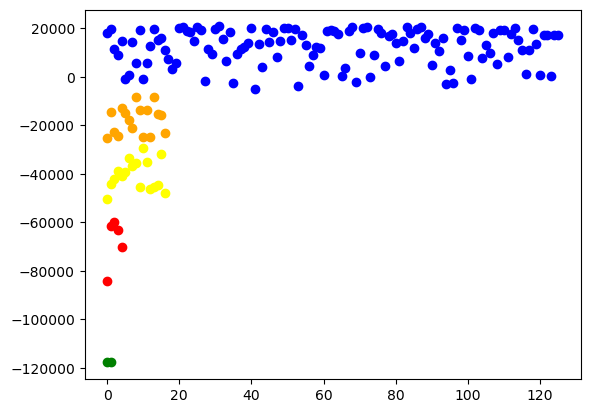

Reduced To:  2 , Number of Classes:  7


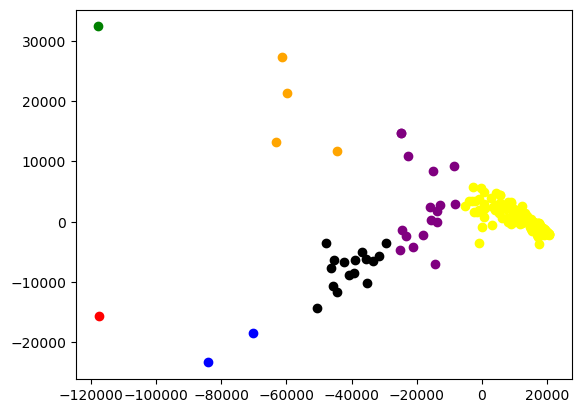

Reduced To:  3 , Number of Classes:  7


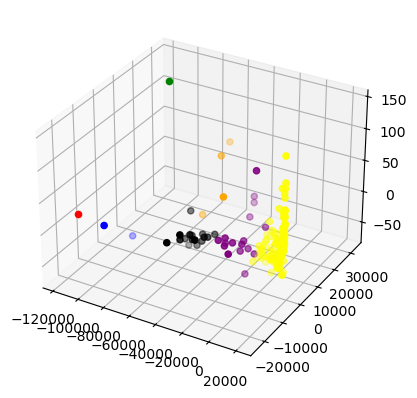

In [5]:
for i in range(3):
    pca = PCA(n_components=i+1)
    pca.fit(data)
    reduced_data = pca.transform(data)
    model = FuzzyEntropy()
    info =model.fit(reduced_data,s=similarity)
    print("Reduced To: ",reduced_data.shape[1],", Number of Classes: ",len(info))
    show(info,dim=i+1)